In [1]:
import os
import pandas as pd
import numpy as np
from box import Box

import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tqdm import tqdm
from typing import Tuple
from collections import OrderedDict

In [2]:
class DirFilePath:
    data_dir = os.path.join(os.getcwd(), 'input', 'data')
    train_dir = os.path.join(data_dir, 'train')
    train_meta = os.path.join(train_dir, 'train.csv')
    train_image_dir = os.path.join(train_dir, 'images')
    eval_dir = os.path.join(data_dir, 'eval')
    eval_meta = os.path.join(eval_dir, 'info.csv')
    eval_image_dir = os.path.join(eval_dir, 'images')

In [3]:
train_df = pd.read_csv(DirFilePath.train_meta)

In [4]:
def set_ages(age):
    if age < 30:
        return 0
    elif age < 60:
        return 1
    else:
        return 2

In [5]:
# train_image_file_df = pd.DataFrame(None, columns = ['path', 'label'])

# for idx, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
#     for img_file in os.listdir(os.path.join(DirFilePath.train_image_dir, row['path'])):
#         if img_file[0] == '.':
#             continue
        
#         if img_file.split('.')[0] == 'normal':
#             mask = 2
#         elif img_file.split('.')[0] == 'incorrect_mask':
#             mask = 1
#         else:
#             mask = 0

#         gender = 0 if row['gender'] == 'male' else 1
#         age = set_ages(row['age'])
#         data = {
#             'path': os.path.join(DirFilePath.train_image_dir, row['path'], img_file),
#             'label': mask * 6 + gender * 3 + age
#         }

#         train_image_file_df = train_image_file_df.append(data, ignore_index=True)
# train_image_file_df.to_csv(os.path.join(os.getcwd(), 'labeling.csv'), index=False)

In [6]:
train_image_file_df = pd.read_csv(os.path.join(os.getcwd(), 'labeling.csv'))

In [7]:
config = {
    'base_df': train_image_file_df,
    'target_col': 'label',
    'num_aug_amount': 1000,
    'num_combi': 3,
}

config = Box(config)

In [8]:
def coutPlotSetting(ax):
    # 사진 테두리를 없앤다
    ax.set(frame_on=False)
    
    # x축 tick을 없애준다.
    ax.tick_params(bottom=False)
    
    # y축 label과 tick을 없앤다.
    ax.set_yticks([])
    ax.set_ylabel('')
    
    # x축의 label을 설정한다.
    ax.set_xlabel('age', fontsize=13, fontweight='semibold')

    return ax


def changeWidth(ax, new_width):
    # 막대의 넓이를 정해준다.
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff * .5)
        patch.set_linewidth(2.0)


def insertValueText(ax, val_height):
    # 막대의 값을 text로 넣는다.
    for idx, patch in enumerate(ax.patches):
        height = patch.get_height()
        height = height if np.isnan(height) else int(height)
        ax.text(
            patch.get_x() + patch.get_width() / 2.,
            height + val_height, 
            height, 
            ha='center', 
            size=10)

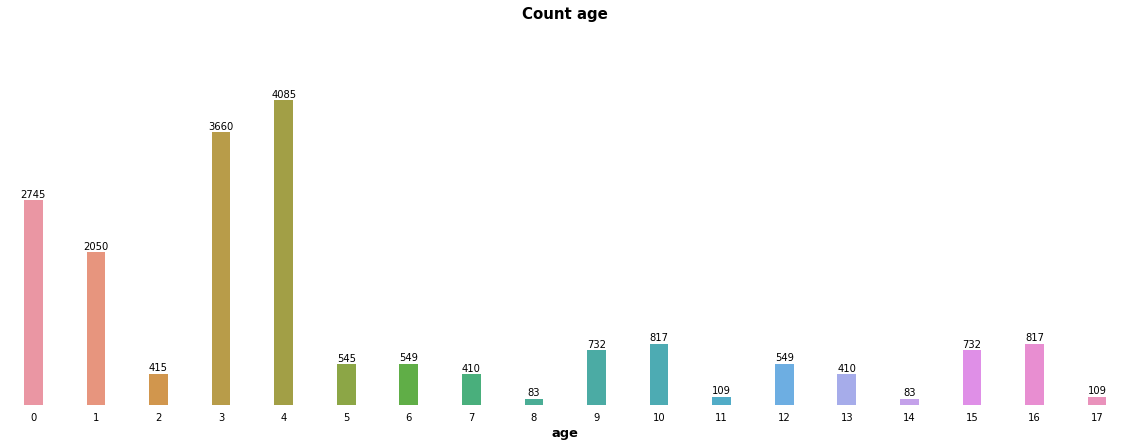

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.countplot(
    x=config.target_col, data=config.base_df,
    ax=ax,
    dodge=True,
    order=sorted(config.base_df[config.target_col].unique()),
)
ax = coutPlotSetting(ax)
insertValueText(ax, 45)
changeWidth(ax, 0.3)
ax.set_title("Count age", fontsize=15, fontweight='semibold')
ax.margins(0.001, 0.25)

In [10]:
def splitDataFrame(df: pd.DataFrame, target_col: str, target_data: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    target_list = boolListRowCondition(df, target_col, target_data)
    re_target_df = df.iloc[target_list]
    
    return re_target_df


def initDataFrame2OrdereeDict(df: pd.DataFrame):
    ret_dict = OrderedDict()
    
    indices = df.index.tolist()
    
    for idx in indices:
        ret_dict[idx] = 0
        
    return ret_dict
    

def createAbnormalImage(df: pd.DataFrame, num_to_create: int, num_combi: int, target_data: int, mix_up_dir: str):
    # 순서를 보장함으로써 sort를 할 수 있다.
    num_used_image_dict = initDataFrame2OrdereeDict(df)
    
    
    for generated_num in tqdm(range(1, num_to_create + 1), total=num_to_create):        
        lists_images_for_avg = []
        cnt = 1
        
        # 사용량이 적은 이미지 3개를 뽑아온다.
        for key in num_used_image_dict.keys():
            
            lists_images_for_avg.append(key)
            
            num_used_image_dict[key] += 1
            if cnt == num_combi:
                break
            cnt += 1
        
        # 3개의 이미지의 평균을 구한다.
        genereted_image = calImageMean(df, lists_images_for_avg)
        
        # 이미지를 저장한다.
        mix_up_label_dir = os.path.join(mix_up_dir, f'aug_{target_data}')
        if not os.path.isdir(mix_up_label_dir):
            os.mkdir(mix_up_label_dir)
            
        Image.fromarray(genereted_image, 'RGB').save(os.path.join(mix_up_label_dir, f'{generated_num}.jpg'))
        
        # 이지미 사용 횟수에 따라 오름차순으로 정렬한다.
        num_used_image_dict = OrderedDict(sorted(num_used_image_dict.items(), key=lambda x: x[1], reverse=False))
        

def calImageMean(df: pd.DataFrame, idx_lists):
    profiles = []
    for idx in idx_lists:
        path = df.loc[idx]['path']
        profile = np.array(Image.open(df.loc[idx]['path']))
        profiles.append(profile)
    
    np_profiles = np.array(profiles)
    
    return np.mean(np_profiles, axis=0).astype(np.uint8)   
        

def augImage(df: pd.DataFrame, target_col: str, target_data: int, num_aug_amount: int, num_combi: int) -> None:
    re_df = splitDataFrame(df, target_col, target_data)
    mix_up_dir = os.path.join(DirFilePath.train_dir, 'aug')
    
    if not os.path.isdir(mix_up_dir):
        os.mkdir(mix_up_dir)
    
    createAbnormalImage(re_df, num_aug_amount - len(re_df), num_combi, target_data, mix_up_dir)
          
def boolListRowCondition(df: pd.DataFrame, target_col: str, target_value) -> list:
    # 조건에 맞는 index를 list 형태로 반환한다.
    return (df[target_col] == target_value).tolist()
    

In [11]:
grouped_df = config.base_df.groupby(config.target_col).count()
for label in grouped_df.index.tolist():
    if grouped_df.loc[label].values[0] < config.num_aug_amount:
        augImage(config.base_df, config.target_col, label, config.num_aug_amount, config.num_combi)

100%|██████████| 891/891 [00:12<00:00, 71.82it/s]
